# Academic Writter Assistant — Notebook

## NLP GROUP PROJECT

**Purpose**: End-to-end notebook for building an autocomplete assistant that predicts next-sentence continuations from paragraph context (100–200 tokens). This notebook contains dataset templates, NSP evaluation approaches, fine-tuning recipe, re-ranking head design, context-window extension ideas, stylistic control methods, vocabulary/token distribution analysis, and evaluation guidance.

**Run notes**: Install `transformers`, `datasets`, `accelerate`, and other libraries in your runtime before executing heavy training cells.

In [ ]:
#!pip install -q transformers datasets accelerate evaluate sentencepiece tokenizers faiss-cpu evaluate nltk

In [1]:
import os
import json, math, random
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
import re
from typing import List, Optional
from transformers import AutoTokenizer, AutoModelForCausalLM, BertTokenizer, BertForNextSentencePrediction, TrainingArguments, Trainer
import nltk
from peft import LoraConfig, get_peft_model, TaskType

# Separating helper functions to declutter the code
import dataset_utils
from model_utils import generate_continuations, all_model_evaluation, nsp_score, lm_score
# Defining the device that the models run on.
device = 'cuda'

# Building a dataset
Here, we create a dataset of contexts and text sentence, using a number of sources. The current implementation only retrieves text from ASAP Essays. Data is first cleaned then loaded into a dataframe with context and next sentence.

In [2]:
df = dataset_utils.build_academic_dataset(tokenizer=None, limit_each=3000)
contexts = df['context']
print(df.head())
print()
print(contexts[0])

Loading datasets...
Loading ASAP Essays
Total raw documents loaded: 723
Generating (context, continuation) pairs...
Generated 720 training pairs.
                                             context  \
0  A long time ago when I was in third grade I ha...   
1  Softball has to be one of the single most grea...   
2  Some people like making people laugh, I love i...   
3  "LAUGHTER" @CAPS1 I hang out with my friends, ...   
4  Well ima tell a story about the time i got @CA...   

                                        continuation  
0  The next day @PERSON2 and I were eating lunch ...  
1  Many of these girls were like sisters to me th...  
2  For example one time I hit myself in the head ...  
3  @CAPS1 I say trash can I really mean trash can...  
4  Then she said stupid @CAPS2 on the bus and com...  

A long time ago when I was in third grade I had a friend @PERSON2 who's mom was in a bad mood. She never laughed and she never smiled. Every time I saw her I would smile at her and all s

# Testing next text generation
Here, we load a GPT2 model to test text generation on the dataset that we have.

In [3]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
# Generating text with the GPT-2 model
context = "Deep reinforcement learning has been widely adopted in robotic navigation."

# Tokenize the input context
inputs = tokenizer(context, return_tensors="pt").to(device)

# Generate continuation using the fine-tuned model
# You can adjust max_new_tokens, do_sample, temperature, top_p as needed
output_ids = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask, # Explicitly pass attention_mask
    max_new_tokens=100, # Generate up to 100 new tokens
    num_return_sequences=1,
    do_sample=True,      # Enable sampling for more diverse outputs
    temperature=0.7,     # Control creativity (lower for less, higher for more)
    top_p=0.9,           # Nucleus sampling
    pad_token_id=tokenizer.eos_token_id
)

# Decode the generated tokens, skipping the input context and special tokens
generated_text = tokenizer.decode(output_ids[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)

print("Context:", context)
print("\nGenerated Continuation:", generated_text.strip())

Context: Deep reinforcement learning has been widely adopted in robotic navigation.

Generated Continuation: But it has its limits, especially when it comes to detecting objects.

This article will show how to use a simple reinforcement learning algorithm to detect objects with a certain speed, and what it can do to help you improve your performance.

The algorithm, known as an artificial intelligence (AI) or Deep Learning, is a neural network with the ability to learn to recognize objects, such as humans. It works by identifying the direction of an object's movement.

An AI may be


# Model Evaluation
Here we are going to test some model evaluation methods for next sentence prediction (NSP). 

## Language model scoring task

This approach treats NSP as a language-model scoring task.

Process:

- Given a sentence pair (A, candidate continuation B)

- Compute the log-likelihood or perplexity of B given A

- Higher probability = more plausible continuation

- Compare scores between true and false continuations

In [5]:
# Run the following code if you want to switch to distilgpt2

# model_name = "distilgpt2"
# lm_tokenizer = AutoTokenizer.from_pretrained(model_name)
# lm_model = AutoModelForCausalLM.from_pretrained(model_name)
# lm_model.to(device)
# lm_model.eval()

score = lm_score(model=model, 
				 tokenizer=tokenizer,
				 context=contexts[0],
				 continuation=df['continuation'][0],
				 device=device)

print("Classification score:", score)

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Classification score: -574.0296041965485


## Binary classification

This approach treats NSP as a binary classification task.

Process:

- Concatenate sentence pair (A + B)

- Feed into a classifier (e.g., BERT, RoBERTa, DeBERTa)

- Output:

  - 1 → B is a valid continuation

  - 0 → B is an invalid continuation

- Evaluate using: Accuracy, Precision, Recall, F1

In [6]:
eval_model = "bert-base-uncased"
eval_tokenizer = BertTokenizer.from_pretrained(eval_model)
eval_model = BertForNextSentencePrediction.from_pretrained(eval_model)
eval_model.eval()
eval_model.to(device)

score = nsp_score(bert_model=eval_model, 
		  bert_tokenizer=eval_tokenizer, 
		  context=contexts[0], 
		  continuation=df['continuation'][0], 
		  device=device)

print("Classification score:", score)

Classification score: 0.9999972581863403


# Model evaluation with Ground Truth

- BERTScore **Semantic similarity**

- ROUGE (ROUGE-1, ROUGE-2, ROUGE-L) **Lexical overlap**

- BLEU **N-gram precision**

In [7]:
# from model_utils import all_model_evaluation

model = model.to(device)
eval_model = eval_model.to(device)

model_score = all_model_evaluation(
		model=model,
		tokenizer=tokenizer,
		bert_model=eval_model,
		bert_tokenizer=eval_tokenizer,
        contexts=[contexts[0]],
        candidates=["He is very good with it"]
    )
model_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tranh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tranh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
c:\Users\tranh\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\tranh\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use Smoothin

{'avg_lm': -471.00285816192627,
 'avg_nsp': 0.010369982570409775,
 'avg_final': -282.58097493201495,
 'bertscore_precision': np.float64(0.4200078547000885),
 'bertscore_recall': np.float64(0.27861446142196655),
 'bertscore_f1': np.float64(0.33500292897224426),
 'rouge1': np.float64(0.02631578947368421),
 'rouge2': np.float64(0.0),
 'rougeL': np.float64(0.02631578947368421),
 'bleu': 3.169663824442922e-242}

# Comparing model
Testing some smaller language models to see which one is the most suitable for our task. These models include:
- gpt2
- EleutherAI/gpt-neo-125M
- facebook/opt-125m
- microsoft/DialoGPT-small


In [8]:
causal_models = [
    "gpt2",
    "EleutherAI/gpt-neo-125M",
    "facebook/opt-125m",
    "microsoft/DialoGPT-small"
]
run = False # Change this to run again
if run:
	model.to(device)
	eval_model.to(device)

	all_model_evaluation_score = []
	for model_name in causal_models:
		print(f"Generating continuations for {model_name}...")
		# Make sure 'gen_model' and 'gen_tokenizer' are available or reloaded if needed
		# (assuming they are from the first model generation cell)
		generate_continuations_list = generate_continuations(model_name, contexts, max_new_tokens=50, device=device)
		print(f"Generated {len(generate_continuations_list)} continuations.")
		print(generate_continuations_list[:5])
		model_score = all_model_evaluation(
			model=model,
			tokenizer=tokenizer,
			bert_model=eval_model,
			bert_tokenizer=eval_tokenizer,
			contexts=contexts,
			candidates=generate_continuations_list,
			device=device
		)
		all_model_evaluation_score.append(model_score)

	print(all_model_evaluation_score)

Generating continuations for gpt2...
Generated 720 continuations.
['We just met at the local elementary school. We went to the playground and the teacher said she was really upset about it. She told me that her son was getting the same grades and that he was getting the same grades as the other kids', 'It was a fun time for me, we had some really great players in the team, but we never really played like the next best team in the state of Florida. We had an unbelievable run of success in the tournament that year but we never really', "I was always interested in learning, but didn't have much of a sense of humor (at least until I was six years old). I was a really weird person, I didn't have a good sense of humor and I didn't really enjoy doing", "I know I'm not one to be too picky with what I eat but when I am you know I like my food and I do think I'm an all time great. I'm very fortunate to have such great friends. @CAPS1", 'She said no no no no no no no no no no no no no no no no no

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tranh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tranh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Generating continuations for EleutherAI/gpt-neo-125M...
Generated 720 continuations.
["I don't know if she was scared or scared by him but she would laugh at him. She didn't think he was a grouch. She was just angry. She would walk away when he was around because she didn't like him or anything", 'I had the opportunity to play with a great young team, and I was ready to try out the team I loved so much. I had been fortunate enough to be part of a great team with some great players. I loved my teammates, I loved', 'I am a big spaz with an interest in art and lots of it, but I do not know how to do it. I have been on a few different projects and am not as obsessed as I should be with these. It is', "I like to have a coffee, and I do some shopping at my local Starbucks. I love the coffee, but I like to have a good beer.\n\nSo, I guess that's why I love to hangout with my friends", 'She was like yes i know that but no i just said yes and what you all were there for? i was there when you we

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tranh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tranh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Generating continuations for facebook/opt-125m...


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/251M [00:00<?, ?B/s]

Generated 720 continuations.
["I would tell him that she would never laugh at him again. That's what it was like for me when I was a child. I would laugh at her and she would laugh at me. I didn't know what to do but I started laughing", 'I have never really felt more passionate about softball than I am now. I love the fact that every time I play softball I feel more passionate about my job and what I am doing, my team, and my family. I am so proud', 'And I really liked the fact that my parents let me do anything.\n\nI also like to make people laugh. I like to make people laugh and make fun of me. I like to make people laugh and make fun of me. I like', 'It’s not about me, it’s about you. I know this is hard for you to hear and I’m sorry you have to go through it, I have a lot of hard time with people that just', "She said you didn't know where i was but she didn't say you were down town. She said she was at your place and we went to her place. I said i'm not sure but she said i'm righ

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tranh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tranh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Generating continuations for microsoft/DialoGPT-small...


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Generated 720 continuations.
['l.', 'mont', '', '', '']


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tranh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tranh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


[{'avg_lm': -703.8060275531014, 'avg_nsp': 0.994303384456457, 'avg_final': -420.29500976294815, 'bertscore_precision': np.float64(0.5591655085955918), 'bertscore_recall': np.float64(0.4462608429889439), 'bertscore_f1': np.float64(0.4955628590460596), 'rouge1': np.float64(0.23596774083884664), 'rouge2': np.float64(0.04867909853567359), 'rougeL': np.float64(0.13608118472992523), 'bleu': 0.007766720070483292}, {'avg_lm': -708.656913375921, 'avg_nsp': 0.9960000638250828, 'avg_final': -423.2021478979021, 'bertscore_precision': np.float64(0.5825267612435329), 'bertscore_recall': np.float64(0.4543276883692921), 'bertscore_f1': np.float64(0.5095118303761156), 'rouge1': np.float64(0.2503192334485458), 'rouge2': np.float64(0.06521160580148405), 'rougeL': np.float64(0.14689371795924383), 'bleu': 0.011251795231246859}, {'avg_lm': -707.2099343914559, 'avg_nsp': 0.9923738791536385, 'avg_final': -422.34121287656654, 'bertscore_precision': np.float64(0.571998118521781), 'bertscore_recall': np.float64(

In [9]:
import pandas as pd

# Convert the list of dictionaries to a DataFrame
df_scores = pd.DataFrame(all_model_evaluation_score)

# Save the DataFrame to a CSV file
df_scores.to_csv('model_evaluation_scores.csv', index=False)

print('Model evaluation scores saved to model_evaluation_scores.csv')

# Display the DataFrame to show the saved data
display(df_scores)

Model evaluation scores saved to model_evaluation_scores.csv


,avg_lm,avg_nsp,avg_final,bertscore_precision,bertscore_recall,bertscore_f1,rouge1,rouge2,rougeL,bleu
0,-703.806028,0.994303,-420.295010,0.559166,0.446261,0.495563,0.235968,0.048679,0.136081,7.766720e-03
1,-708.656913,0.996000,-423.202148,0.582527,0.454328,0.509512,0.250319,0.065212,0.146894,1.125180e-02
2,-707.209934,0.992374,-422.341213,0.571998,0.446039,0.500368,0.245240,0.061434,0.144236,1.122598e-02
3,-600.890825,0.475803,-359.582890,0.388715,0.184334,0.247126,0.003028,0.000165,0.002823,1.681726e-208


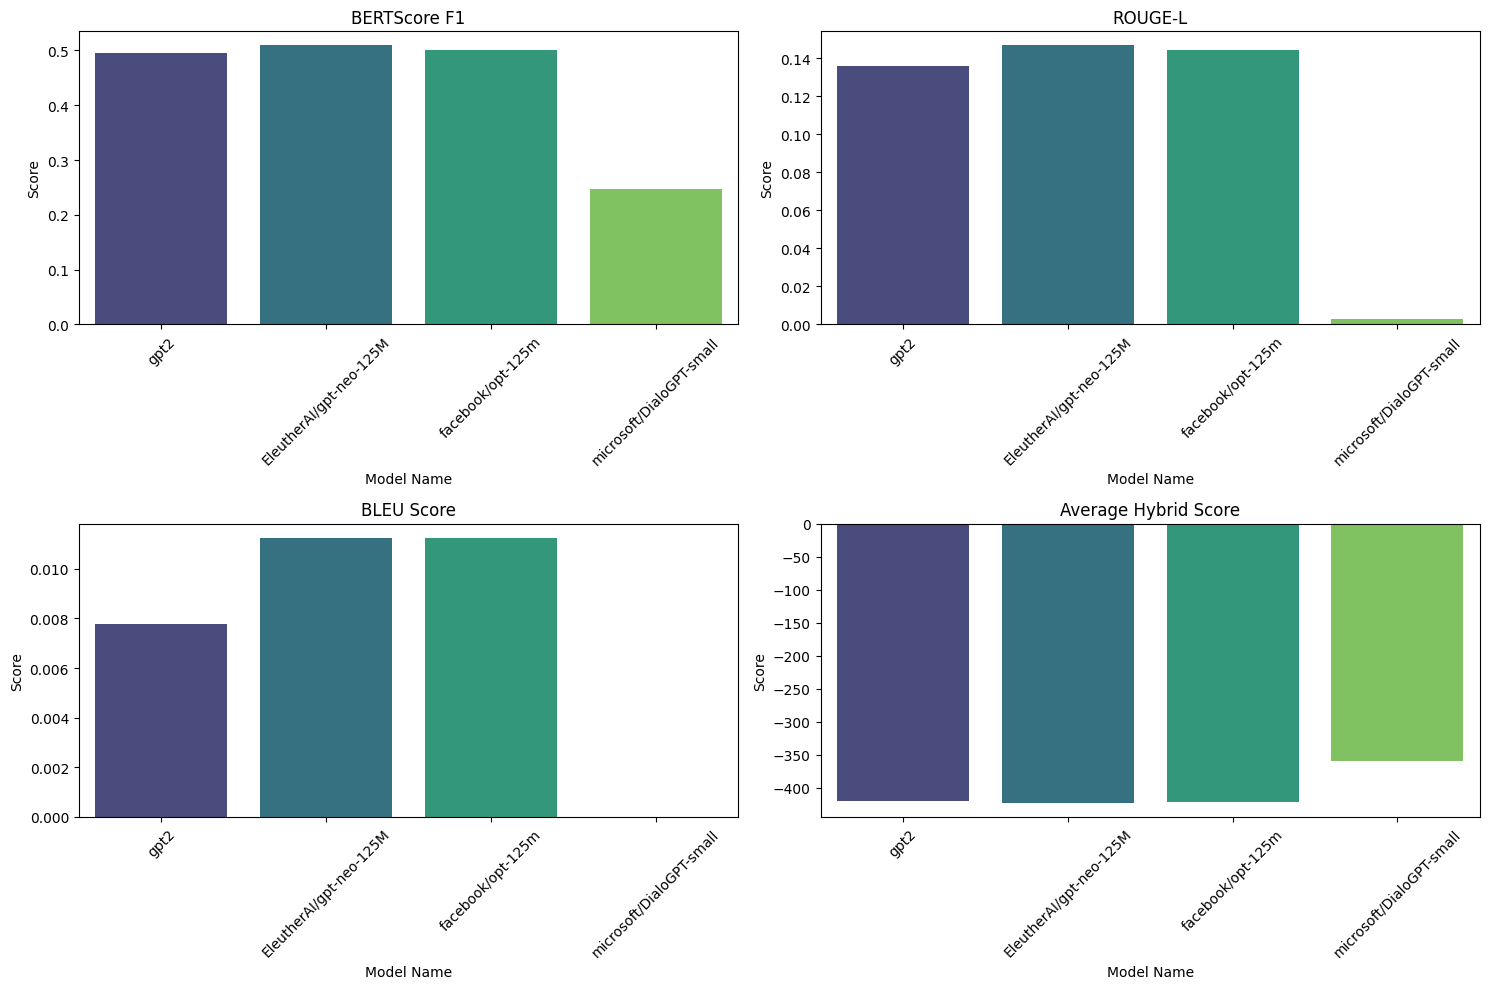

Evaluation metrics plots saved to model_evaluation_metrics.png


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure `df_scores` and `causal_models` are available
# If `causal_models` is not updated or might be out of sync with df_scores rows,
# we might need to recreate it or infer model names.
# For now, assuming causal_models is still the list of models that generated the scores.

# Adding model names to the DataFrame for easier plotting
model_names = causal_models # Use the last set of causal_models that was evaluated
df_scores['model_name'] = model_names[:len(df_scores)] # Ensure lengths match

metrics_to_plot = [
    'bertscore_f1',
    'rougeL',
    'bleu',
    'avg_final'
]

metric_titles = {
    'bertscore_f1': 'BERTScore F1',
    'rougeL': 'ROUGE-L',
    'bleu': 'BLEU Score',
    'avg_final': 'Average Hybrid Score'
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(x='model_name', y=metric, data=df_scores, ax=axes[i], palette='viridis', hue='model_name', legend=False)
    axes[i].set_title(metric_titles[metric])
    axes[i].set_xlabel('Model Name')
    axes[i].set_ylabel('Score')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('model_evaluation_metrics.png')
plt.show()

print("Evaluation metrics plots saved to model_evaluation_metrics.png")

## Choosing Best Pretrained-Model

From the Result we can conclude that Overall Best Model: → GPT-Neo 125M (Model 1)

It gives the best balance between likelihood scoring, semantic understanding, lexical overlap, and NSP performance.